# Introducción


Para el entrenamiento del modelo en la detección de reseñas falsas, usaremos el conjunto de datos proporcionados por la plataforma <a href="https://www.yelp.es">Yelp</a>, conocidos como <A Href="https://www.kaggle.com/datasets/yelp-dataset/yelp-dataset/data">Yelp Dataset</A>, este dataset es un conjunto de datos público que la empresa Yelp pone a disposición para fines académicos, educativos y de investigación personal.  En esencia, la colección de datos son un subconjunto de datos reales extraídos de la plataforma de Yelp y anonimizado hasta cierto punto.

<a href="https://business.yelp.com/data/resources/open-dataset/"><img src=https://business.yelp.com/wp-content/themes/yelp-b2b/assets/branding/yelp-data-logo.svg></a>

Tras seleccionar las reseñas del conjunto de datos de yelp, realizamos la conexión con la IA DeepSeek, ya que el uso de este modelo de IA avanzada se justifica por su potente capacidad de procesamiento del lenguaje natural (PLN). Estos modelos pueden analizar a fondo el texto de una reseña, detectando patrones lingüísticos, anomalías, inconsistencias y otros indicios sutiles que a menudo distinguen el lenguaje natural y detallado de una experiencia real frente a la artificialidad o generalidad de una reseña fraudulenta.

Al modelo de DeepSeek se instruirá el Dataset de reseñas seleccionadas para que evalúe y clasifique cada una de las reseñas ajustadas a alguna de las siguientes categorías:
* Genuina positiva.
* Genuina negativa.
* Falsa positiva.
* Falsa negativa.

<a href="https://business.yelp.com/data/resources/open-dataset/"><img src=https://cdn.deepseek.com/logo.png></a>

Además a los datos de entrenamiento seleccionados de Yelp, agregamos dentro de la categoría genuina positiva y genuina negativa el dataset de <a href="https://www.kaggle.com/datasets/ma7555/the-sfu-review-corpus-negation-annotated/data">"The SFU Review Corpus: Negation Annotated"</a>, está principalmente anotado para características lingüísticas como la negación y la especulación.

# Librerías

In [1]:
import polars as pl
import pandas as pd
import pyarrow
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('Solarize_Light2') 
import seaborn as sns
import openai
from openai import OpenAI
import kagglehub

import json
import time
start_time_global = time.time()
import os
from dotenv import load_dotenv
explicit_work_path = f'/home/aam/fakereviews/'
load_dotenv(dotenv_path=f'{explicit_work_path}.env')

color = '\033[1m\033[38;5;208m' 
print(f"{color}Versión pandas: {pd.__version__}")
print(f"{color}Versión polars: {pl.__version__}")
print(f"{color}Versión pyarrow: {pyarrow.__version__}")
print(f"{color}Versión numpy: {np.__version__}")
print(f"{color}Versión OpenAI: {openai.__version__}")

Versión pandas: 2.2.3
Versión polars: 1.27.1
Versión pyarrow: 16.1.0
Versión numpy: 2.0.1
Versión OpenAI: 1.75.0


# Datos

## Yelp dataset

El dataset se distribuye en varios archivos en formato JSON (JavaScript Object Notation), cada uno representando un tipo diferente de información. Los componentes principales suelen ser:

* Información de Negocios (business.json): Detalles sobre los establecimientos listados en Yelp, como:
    * Nombre, dirección, coordenadas geográficas.
    * Categorías (restaurante, tienda, peluquería, etc.).
    * Atributos (acepta tarjetas, tiene Wi-Fi, bueno para grupos, etc.).
    * Horarios de apertura.
    * Puntuación media (estrellas).
    * Número de reseñas recibidas.

* Reseñas (review.json): El texto de las reseñas escritas por los usuarios, junto con metadatos como:
    * El texto completo de la reseña.
    * La calificación en estrellas otorgada (de 1 a 5).
    * La fecha de la reseña.
    * El ID del usuario que la escribió.
    * El ID del negocio reseñado.
    * Votos recibidos por la reseña (útil, divertida, genial - "useful, funny, cool").

* Información de Usuarios (user.json): Datos sobre los usuarios que escriben las reseñas:
    * ID del usuario.
    * Nombre (a menudo solo el primer nombre o un identificador).
    * Número total de reseñas escritas.
    * Tiempo siendo usuario de Yelp.
    * Lista de amigos (IDs de otros usuarios).
    * Puntuación media de las reseñas que ha escrito.
    * Número total de votos recibidos por sus reseñas.
    * Estado "Elite" (si lo tiene y en qué años).

* Check-ins (checkin.json): Registros de cuándo los usuarios han indicado ("hecho check-in") que han visitado un negocio.

* Consejos (tip.json): Textos cortos o consejos que los usuarios dejan sobre los negocios, distintos de las reseñas completas.

In [6]:
# Fichero de reseñas
yelp_review_file_path = f'{explicit_work_path}yelp_academic_dataset_review.json'
# Fichero de Información de usuarios
yelp_user_file_path = f'{explicit_work_path}yelp_academic_dataset_user.json'
# Fichero Consejos
yelp_tip_file_path = f'{explicit_work_path}yelp_academic_dataset_tip.json'
# Fichero de Check-ins
yelp_chekin_file_path = f'{explicit_work_path}yelp_academic_dataset_checkin.json'
# Fichero de Información de negocios
yelp_business_file_path = f'{explicit_work_path}yelp_academic_dataset_business.json'

## The SFU Review Corpus - Negation Annotated

Este corpus comprende un conjunto de reseñas recopiladas originalmente en 2004 del sitio web "Epinions.org".  El conjunto de datos está categorizado temáticamente, abarcando dominios como Libros, Automóviles, Computadoras, Utensilios de cocina, Hoteles, Películas, Música y Teléfonos. Para cada una de estas categorías, el corpus incluye un subconjunto equilibrado de 25 reseñas clasificadas como positivas y 25 como negativas. La clasificación binaria de polaridad (positiva/negativa) se basó en la etiqueta explícita de "recomendado" o "no recomendado" proporcionada por el autor de la reseña original en Epinions.
Todas estas reseñas serán utilizadas para el dataset de entrenamiento del modelo y serán categorizadas como Genuinas positivas y Genuinas negativas.

Los datos del dataset están etiquetados con 0 y 1, para nuestro utilización convertiremos los 0 a Genuine negative y los 1 a Genuine positive.

In [7]:
# kagglehub_dataset_id_sfu = 'ma7555/the-sfu-review-corpus-negation-annotated'
# path = kagglehub.dataset_download(kagglehub_dataset_id_sfu,path=f'{explicit_work_path}')
# print("Path to dataset files:", path)

In [8]:
#!/bin/bash
!curl -L -k -o ~/fakereviews/review-corpus-negation-annotated.zip\
  https://www.kaggle.com/api/v1/datasets/download/ma7555/the-sfu-review-corpus-negation-annotated
!unzip ./fakereviews/review-corpus-negation-annotated.zip -d ./fakereviews/ && rm ./fakereviews/review-corpus-negation-annotated.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  606k  100  606k    0     0   498k      0  0:00:01  0:00:01 --:--:-- 2015k
Archive:  ./fakereviews/review-corpus-negation-annotated.zip
  inflating: ./fakereviews/SFU_Corpus.csv  


In [9]:
# Fichero de reseñas
sfu_review_file_path = f'{explicit_work_path}SFU_Corpus.csv'

# Análisis Exploratorio

A continuación realizamos un análisis exploratorio de datos (EDA), motivado principalmente por la naturaleza intrínseca y la heterogeneidad de los datos. Este proceso se desarrollará siguiendo una serie de etapas consideradas fundamentales para el propósito establecido.

1. Entender la estructura y complejidad de los datos:
    
    Cada uno de los conjuntos de datos puede estar integrado por múltiples archivos, como se observa en el caso del "Yelp Dataset". En consecuencia, se recomienda la unificación de estos archivos para simplificar la comprensión de la información y ofrecer una perspectiva clara del volumen de los datos, que podrían comprender millones, miles o cientos de reseñas. Adicionalmente, resulta indispensable verificar el formato y los tipos de datos, puesto que las calificaciones de estrellas podrían ser de carácter numérico, las fechas podrían exhibir formatos no válidos, o campos numéricos y podrían encontrarse almacenados como texto.

2. Evaluar la Calidad de los Datos:

    Es importante detectar valores faltantes y determinar la estrategia para su tratamiento, ya sea mediante su eliminación o imputación (ej. negocios que no tienen especificadas las horas).  Asimismo, detectar los errores, incosistencias o datos carentes de lógica (ej. una reseña con 0 estrellas si el rango es 1-5), lo que conduce principalmente a la detección de valores atípicos.

3. Descubrir Patrones e Insights Preliminares:

     El Análisis Exploratorio de Datos (EDA) en el contexto de reseñas requiere la evaluación de la distribución y la correlaciones entre el conjunto de los datos, ej. los precios, la longitud de las reseñas y el tono empleado, así como los patrones de comportamiento entre los usuarios con más votaciones y los usuarios promedio. Asimismo, el estudio de las variaciones temporales observadas en las reseñas y las valoraciones.

4. Guiar el Análisis Posterior y Modelado:

    El Análisis Exploratorio de Datos (EDA) es fundamental para formular hipótesis basadas en patrones, crear nuevas variables significativas (ingeniería de características), seleccionar modelos de Machine Learning adecuados según la distribución de los datos y validar los supuestos de los modelos estadísticos.

## Yelp dataset

A continuación realizamos un EDA al conjunto de datos de Yelp.

### Estructura de los datos

#### Business - Establecimientos

In [10]:
print(f"Iniciando el procesamiento del archivo: {yelp_business_file_path}")
df_lazy_business_pl:pl.lazyframe.frame.LazyFrame = None
try:
    #Lee el archivo especificado y no lo carga inmediatamente en la memoria
    df_lazy_business_pl = pl.scan_ndjson(yelp_business_file_path)
except Exception as e:
    print(f"\nOcurrió un error durante el procesamiento:")
    print(e)
else:
    print("La operación fue exitosa.")
    # Muestra las primeras 5 filas del DataFrame    
    display(df_lazy_business_pl.collect(engine='streaming').limit(25).head(2))

Iniciando el procesamiento del archivo: ./fakereviews/yelp_academic_dataset_business.json
La operación fue exitosa.


business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
str,str,str,str,str,str,f64,f64,f64,i64,i64,struct[33],str,struct[7]
"""Pns2l4eNsfO8kk83dixA6A""","""Abby Rappoport, LAC, CMQ""","""1616 Chapala St, Ste 2""","""Santa Barbara""","""CA""","""93101""",34.426679,-119.711197,5.0,7,0,"{null,null,null,null,null,null,null,null,null,null,null,""True"",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null}","""Doctors, Traditional Chinese M…",null
"""mpf3x-BjTdTEA3yCZrAYPw""","""The UPS Store""","""87 Grasso Plaza Shopping Cente…","""Affton""","""MO""","""63123""",38.551126,-90.335695,3.0,15,1,"{null,""True"",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null}","""Shipping Centers, Local Servic…","{""0:0-0:0"",""8:0-18:30"",""8:0-18:30"",""8:0-18:30"",""8:0-18:30"",""8:0-14:0"",null}"


##### Ajuste de la calidad del dato
A continuación realizaremos la ordenación de las categorías en cada una de las celdas de forma alfabética, ya que esto facilitará cualquier explotación de la información.

In [11]:
start_time=time.time()
try:
    df_data_business_pl:pl.dataframe.frame.DataFrame = df_lazy_business_pl.collect(engine='streaming').with_columns(
        pl.col('categories')
        # 1. Dividir la cadena en una lista de strings, manejando nulos
        .str.split(',')
        # 2. Dentro de cada lista resultante, aplicar operaciones a cada elemento:
        .list.eval(
            # 2a. Quitar espacios en blanco al inicio/final de cada categoría
            pl.element().str.strip_chars()
        )
        # 3. Ordenar los elementos dentro de cada lista
        .list.sort()
        # 4. Unir los elementos de la lista de nuevo en una cadena, separados por ", "
        .list.join(', ')
    )
except Exception as e:
    print(f"An error occurred: {e}")
else: 
    print(f"La operación fue exitosa en {time.time()-start_time:.2f}seg")  
    # Muestra las primeras 5 filas del DataFrame  
    display(df_data_business_pl.limit(25).head(5))  

La operación fue exitosa en 1.69seg


business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
str,str,str,str,str,str,f64,f64,f64,i64,i64,struct[33],str,struct[7]
"""Pns2l4eNsfO8kk83dixA6A""","""Abby Rappoport, LAC, CMQ""","""1616 Chapala St, Ste 2""","""Santa Barbara""","""CA""","""93101""",34.426679,-119.711197,5.0,7,0,"{null,null,null,null,null,null,null,null,null,null,null,""True"",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null}","""Acupuncture, Doctors, Health &…",null
"""mpf3x-BjTdTEA3yCZrAYPw""","""The UPS Store""","""87 Grasso Plaza Shopping Cente…","""Affton""","""MO""","""63123""",38.551126,-90.335695,3.0,15,1,"{null,""True"",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null}","""Local Services, Mailbox Center…","{""0:0-0:0"",""8:0-18:30"",""8:0-18:30"",""8:0-18:30"",""8:0-18:30"",""8:0-14:0"",null}"
"""tUFrWirKiKi_TAnsVWINQQ""","""Target""","""5255 E Broadway Blvd""","""Tucson""","""AZ""","""85711""",32.223236,-110.880452,3.5,22,0,"{""{'garage': False, 'street': False, 'validated': False, 'lot': True, 'valet': False}"",""True"",null,""False"",""False"",""False"",""False"",null,null,null,""2"",""False"",""False"",""False"",null,null,""False"",""u'no'"",""True"",""False"",""False"",null,""True"",null,null,null,null,null,null,null,null,null,null}","""Department Stores, Electronics…","{""8:0-22:0"",""8:0-22:0"",""8:0-22:0"",""8:0-22:0"",""8:0-23:0"",""8:0-23:0"",""8:0-22:0""}"
"""MTSW4McQd7CbVtyjqoe9mw""","""St Honore Pastries""","""935 Race St""","""Philadelphia""","""PA""","""19107""",39.955505,-75.155564,4.0,80,1,"{""{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}"",""False"",null,""False"",null,""True"",""True"",""u'none'"",null,null,""1"",""False"",null,null,null,null,""False"",""u'free'"",null,null,null,null,""True"",null,null,null,null,null,null,null,null,null,null}","""Bakeries, Bubble Tea, Coffee &…","{""7:0-20:0"",""7:0-20:0"",""7:0-20:0"",""7:0-20:0"",""7:0-21:0"",""7:0-21:0"",""7:0-21:0""}"
"""mWMc6_wTdE0EUBKIGXDVfA""","""Perkiomen Valley Brewery""","""101 Walnut St""","""Green Lane""","""PA""","""18054""",40.338183,-75.471659,4.5,13,1,"{""{'garage': None, 'street': None, 'validated': None, 'lot': True, 'valet': False}"",""True"",null,null,null,""False"",""True"",null,null,""True"",null,null,null,null,null,null,null,null,""True"",null,null,null,""True"",null,null,null,null,null,null,null,null,null,null}","""Breweries, Brewpubs, Food""","{null,null,""14:0-22:0"",""16:0-22:0"",""12:0-22:0"",""12:0-22:0"",""12:0-18:0""}"


#### Chekin - Ha visitado el establecimiento

In [12]:
print(f"Iniciando el procesamiento del archivo: {yelp_chekin_file_path}")
df_data_chekin_pl = None
try:
    #Lee el archivo especificado y no lo carga inmediatamente en la memoria
    df_data_chekin = pl.scan_ndjson(yelp_chekin_file_path)
    #Lee los datos del archivo, los procesa y los almacena en un DataFrame
    df_data_chekin_pl = df_data_chekin.limit(25).collect(engine='streaming') 
except Exception as e:
    print(f"\nOcurrió un error durante el procesamiento:")
    print(e)
else:
    print("La operación fue exitosa.")
    # Muestra las primeras 5 filas del DataFrame    
    display(df_data_chekin_pl.limit(25).head(5))

Iniciando el procesamiento del archivo: ./fakereviews/yelp_academic_dataset_checkin.json
La operación fue exitosa.


business_id,date
str,str
"""---kPU91CF4Lq2-WlRu9Lw""","""2020-03-13 21:10:56, 2020-06-0…"
"""--0iUa4sNDFiZFrAdIWhZQ""","""2010-09-13 21:43:09, 2011-05-0…"
"""--30_8IhuyMHbSOcNWd6DQ""","""2013-06-14 23:29:17, 2014-08-1…"
"""--7PUidqRWpRSpXebiyxTg""","""2011-02-15 17:12:00, 2011-07-2…"
"""--7jw19RH9JKXgFohspgQw""","""2014-04-21 20:42:11, 2014-04-2…"


#### Review - Reseñas

In [13]:
print(f"Iniciando el procesamiento del archivo: {yelp_review_file_path}")
df_lazy_review_pl = None
try:
    #Lee el archivo especificado y no lo carga inmediatamente en la memoria
    df_lazy_review_pl = pl.scan_ndjson(yelp_review_file_path)
    #Lee los datos del archivo, los procesa y los almacena en un DataFrame
except Exception as e:
    print(f"\nOcurrió un error durante el procesamiento:")
    print(e)
else:
    print("La operación fue exitosa.")

Iniciando el procesamiento del archivo: ./fakereviews/yelp_academic_dataset_review.json
La operación fue exitosa.


Cargar todas las reseñas

In [14]:
start_time=time.time()
try:    
    df_data_review_pl = df_lazy_review_pl.collect(engine='streaming')
except Exception as e:
    print(f"\nOcurrió un error durante el procesamiento:")
    print(e)
else:
    print("La operación fue exitosa.")
    print(f"La operación fue exitosa en {time.time()-start_time:.2f}seg")
    display(df_data_review_pl.head(5))

La operación fue exitosa.
La operación fue exitosa en 18.87seg


review_id,user_id,business_id,stars,useful,funny,cool,text,date
str,str,str,f64,i64,i64,i64,str,str
"""KU_O5udG6zpxOg-VcAEodg""","""mh_-eMZ6K5RLWhZyISBhwA""","""XQfwVwDr-v0ZS3_CbbE5Xw""",3.0,0,0,0,"""If you decide to eat here, jus…","""2018-07-07 22:09:11"""
"""BiTunyQ73aT9WBnpR9DZGw""","""OyoGAe7OKpv6SyGZT5g77Q""","""7ATYjTIgM3jUlt4UM3IypQ""",5.0,1,0,1,"""I've taken a lot of spin class…","""2012-01-03 15:28:18"""
"""saUsX_uimxRlCVr67Z4Jig""","""8g_iMtfSiwikVnbP2etR0A""","""YjUWPpI6HXG530lwP-fb2A""",3.0,0,0,0,"""Family diner. Had the buffet. …","""2014-02-05 20:30:30"""
"""AqPFMleE6RsU23_auESxiA""","""_7bHUi9Uuf5__HHc_Q8guQ""","""kxX2SOes4o-D3ZQBkiMRfA""",5.0,1,0,1,"""Wow! Yummy, different, delic…","""2015-01-04 00:01:03"""
"""Sx8TMOWLNuJBWer-0pcmoA""","""bcjbaE6dDog4jkNY91ncLQ""","""e4Vwtrqf-wpJfwesgvdgxQ""",4.0,1,0,1,"""Cute interior and owner (?) ga…","""2017-01-14 20:54:15"""


Debido a que la longitud de las reseñas, debido a que las reseñas más largas tienden a contener más información contextual, detalles y características lingüísticas que pueden ser cruciales para identificar patrones asociados con reseñas falsas, pero no todo el texto en una reseña es útil, por ejemplo una reseña muy larga no es necesariamente útil o relevante para determinar si es falsa, ya que, pueden contener mucha información superflua, anécdotas personales o repeticiones que actúan como "ruido" y pueden dificultar que el modelo identifique las señales clave.

In [15]:
start_time=time.time()
try: 
    filter_reviews_min_lenght = 256
    filter_reviews_max_lenght = 512
    print("-" * 50)
    df_data_review_pl = df_data_review_pl.with_columns(
        pl.col("text").str.len_chars().alias("length")
    )
    print(f'Total reseñas seleccionadas: {df_data_review_pl.shape[0]}')
    df_data_review_pl = df_data_review_pl.filter(
       (pl.col("length") >= filter_reviews_min_lenght) & (pl.col("length") <= filter_reviews_max_lenght)
    ).sort('length', descending=False)
except Exception as e:
    print(f"\nOcurrió un error durante el procesamiento:")
    print(e)
else:
    print("La operación fue exitosa.")
    print(f"La operación fue exitosa en {time.time()-start_time:.2f}seg")
    print(f'Total reseñas seleccionadas {df_data_review_pl.shape[0]} con una longitud en el texto superior a {filter_reviews_min_lenght} y menor a {filter_reviews_max_lenght}')    
    display(df_data_review_pl.head(5))


--------------------------------------------------


Total reseñas seleccionadas: 6990280
La operación fue exitosa.
La operación fue exitosa en 1.26seg
Total reseñas seleccionadas 2191389 con una longitud en el texto superior a 256 y menor a 512


review_id,user_id,business_id,stars,useful,funny,cool,text,date,length
str,str,str,f64,i64,i64,i64,str,str,u32
"""4KpIldEM-tdnrJLqYzRfZQ""","""Z5j9Xw_G0c7M2b1-iS67wg""","""HTqXI5S2XcSlh_ylx9sE6g""",5.0,1,1,1,"""I've only had the cannolis her…","""2018-03-23 14:35:33""",256
"""ZWpJSXuUDFnw8_NZh6JqYA""","""BxHWwl5P0NH34Ei9ZdaBjQ""","""lwdkX7KcibM4mDqpDfK7JA""",4.0,0,0,0,"""Love the lamb gyros plate. It'…","""2013-10-03 12:41:19""",256
"""asXAASywqWEx4lS6PU-r_g""","""lTx02VrbU_YYRffLehyVgg""","""TgbI5_wXWa82NBVwkvC0yQ""",5.0,0,0,0,"""We've stayed at this Courtyard…","""2017-04-19 20:52:17""",256
"""7L1JrN4YIEVy98m_8_ebhA""","""QjyrAYCPSc93N5NVTMWUnA""","""gzln_L7ch8z-Ob6autmumw""",2.0,1,0,0,"""We were drawn in by the full p…","""2015-01-03 23:53:47""",256
"""sFzKQcym9BcMa3HceZ4AqQ""","""9jlF9iq-Zz8NhQ-ezrCCNQ""","""YKpZ2Ml0NZoYZ5eb3r_Cdg""",5.0,0,0,0,"""Hands down, one of the BEST st…","""2016-06-12 04:10:33""",256


#### Tips - Consejos

In [16]:
print(f"Iniciando el procesamiento del archivo: {yelp_tip_file_path}")
df_data_tip_pl = None
try:
    #Lee el archivo especificado y no lo carga inmediatamente en la memoria
    df_data_tip = pl.scan_ndjson(yelp_tip_file_path)
    #Lee los datos del archivo, los procesa y los almacena en un DataFrame
    df_data_tip_pl = df_data_tip.limit(25).collect(engine='streaming')
except Exception as e:
    print(f"\nOcurrió un error durante el procesamiento:")
    print(e)
else:
    print("La operación fue exitosa.")
    # Muestra las primeras 5 filas del DataFrame    
    display(df_data_tip_pl.limit(25).head(5))

Iniciando el procesamiento del archivo: ./fakereviews/yelp_academic_dataset_tip.json
La operación fue exitosa.


user_id,business_id,text,date,compliment_count
str,str,str,str,i64
"""AGNUgVwnZUey3gcPCJ76iw""","""3uLgwr0qeCNMjKenHJwPGQ""","""Avengers time with the ladies.""","""2012-05-18 02:17:21""",0
"""NBN4MgHP9D3cw--SnauTkA""","""QoezRbYQncpRqyrLH6Iqjg""","""They have lots of good deserts…","""2013-02-05 18:35:10""",0
"""-copOvldyKh1qr-vzkDEvw""","""MYoRNLb5chwjQe3c_k37Gg""","""It's open even when you think …","""2013-08-18 00:56:08""",0
"""FjMQVZjSqY8syIO-53KFKw""","""hV-bABTK-glh5wj31ps_Jw""","""Very decent fried chicken""","""2017-06-27 23:05:38""",0
"""ld0AperBXk1h6UbqmM80zw""","""_uN0OudeJ3Zl_tf6nxg5ww""","""Appetizers.. platter special f…","""2012-10-06 19:43:09""",0


#### Users - Usuarios

In [17]:
print(f"Iniciando el procesamiento del archivo: {yelp_user_file_path}")
df_data_user_pl = None
try:
    #Lee el archivo especificado y no lo carga inmediatamente en la memoria
    df_data_user = pl.scan_ndjson(yelp_user_file_path)
    #Lee los datos del archivo, los procesa y los almacena en un DataFrame
    df_data_user_pl = df_data_user.limit(25).collect(engine='streaming')
except Exception as e:
    print(f"\nOcurrió un error durante el procesamiento:")
    print(e)
else:
    print("La operación fue exitosa.")
    # Muestra las primeras 5 filas del DataFrame    
    display(df_data_user_pl.limit(25).head(5))

Iniciando el procesamiento del archivo: ./fakereviews/yelp_academic_dataset_user.json
La operación fue exitosa.


user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
str,str,i64,str,i64,i64,i64,str,str,i64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
"""qVc8ODYU5SZjKXVBgXdI7w""","""Walker""",585,"""2007-01-25 16:47:26""",7217,1259,5994,"""2007""","""NSCy54eWehBJyZdG2iE84w, pe42u7…",267,3.91,250,65,55,56,18,232,844,467,467,239,180
"""j14WgRoU_-2ZE1aw1dXrJg""","""Daniel""",4333,"""2009-01-25 04:35:42""",43091,13066,27281,"""2009,2010,2011,2012,2013,2014,…","""ueRPE0CX75ePGMqOFVj6IQ, 52oH4D…",3138,3.74,1145,264,184,157,251,1847,7054,3131,3131,1521,1946
"""2WnXYQFK0hXEoTxPtV2zvg""","""Steph""",665,"""2008-07-25 10:41:00""",2086,1010,1003,"""2009,2010,2011,2012,2013""","""LuO3Bn4f3rlhyHIaNfTlnA, j9B4Xd…",52,3.32,89,13,10,17,3,66,96,119,119,35,18
"""SZDeASXq7o05mMNLshsdIA""","""Gwen""",224,"""2005-11-29 04:38:33""",512,330,299,"""2009,2010,2011""","""enx1vVPnfdNUdPho6PH_wg, 4wOcvM…",28,4.27,24,4,1,6,2,12,16,26,26,10,9
"""hA5lMy-EnncsH4JoR-hFGQ""","""Karen""",79,"""2007-01-05 19:40:59""",29,15,7,"""""","""PBK4q9KEEBHhFvSXCUirIw, 3FWPpM…",1,3.54,1,1,0,0,0,1,1,0,0,0,0


### Patrones visuales de los datos

#### Business - Establecimientos
A continuación hacemos una exploración visual de las categorías de los establecimientos y así respresentar el grupo de categorías que más comentarios contiene.

In [18]:
start_time=time.time()
try:
    #Agrupación por la categoría
    max_categorias_business = 30
    df_count_categories_business_pl = df_data_business_pl.group_by("categories").agg(
        pl.len().alias("count")  # pl.count() cuenta las filas en cada grupo
    ).sort("count", descending=True)
    df_count_categories_business_pl = df_count_categories_business_pl.limit(max_categorias_business)
    
except Exception as e:
    print(f"An error occurred: {e}")
else: 
    print(f"La operación fue exitosa en {time.time()-start_time:.2f}seg")  
    # Muestra las primeras 5 filas del DataFrame  
    print("-" * 50 + "\n")
    # Ver el resultado
    print(f'Resultado de la agrupación, total {df_count_categories_business_pl.shape}')
    display(df_count_categories_business_pl.head(5)) 

La operación fue exitosa en 0.13seg
--------------------------------------------------

Resultado de la agrupación, total (30, 2)


categories,count
str,u32
"""Beauty & Spas, Nail Salons""",1946
"""Pizza, Restaurants""",1758
"""Event Planning & Services, Hot…",1631
"""Mexican, Restaurants""",1400
"""Chinese, Restaurants""",1359


Convertir a pandas para graficar las categorias más usadas por los establecimientos.

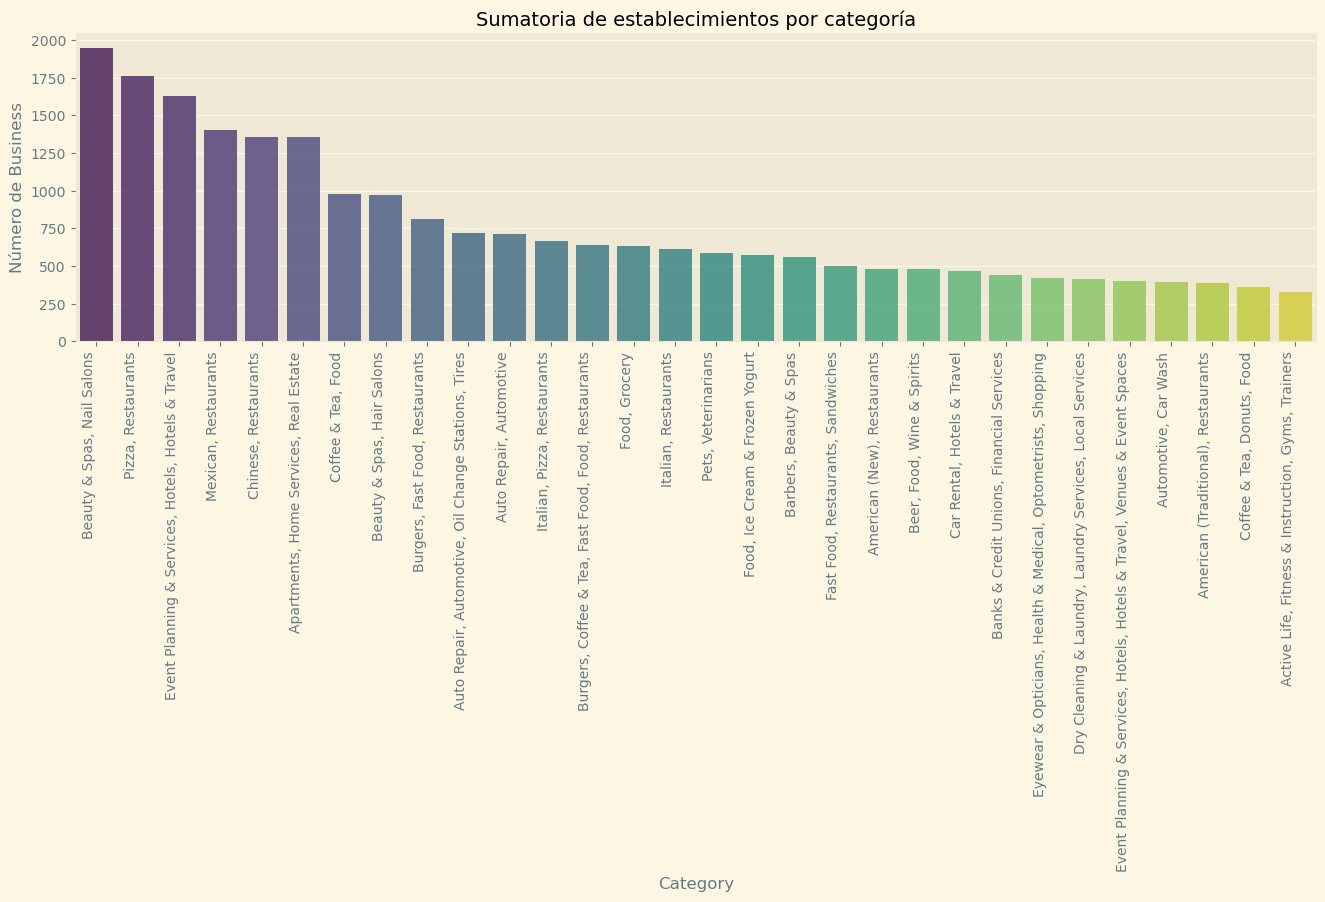

Total establecimientos: 23009 de 150346


In [19]:
# Convertir a pandas para graficar
df_category_counts_pd = df_count_categories_business_pl.to_pandas()
plt.figure(figsize=(16,4))
sns.barplot(x='categories', y='count',data=df_category_counts_pd, alpha=0.8, palette='viridis',hue='categories')
plt.title("Sumatoria de establecimientos por categoría",fontsize=14)
plt.xticks(rotation=90, ha='right')
plt.ylabel('Número de Business', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.show()
print(f'Total establecimientos: {df_category_counts_pd['count'].sum()} de {df_data_business_pl.shape[0]}')


Extracción de los identificadores de los establecimientos que están dentro del conjunto de categorías más usadas.

In [20]:
# A continuación filtrar los business según las categorías seleccionadas
df_data_business_filer_pl = df_data_business_pl.filter(
    pl.col('categories').is_in(df_count_categories_business_pl['categories'])
)
print('-' * 50)
print(f'Total de establecimientos seleccionados {df_data_business_filer_pl.shape[0]}')
print('-' * 50)
display(df_data_business_filer_pl.head(2))

--------------------------------------------------
Total de establecimientos seleccionados 23009
--------------------------------------------------


business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
str,str,str,str,str,str,f64,f64,f64,i64,i64,struct[33],str,struct[7]
"""9OG5YkX1g2GReZM0AskizA""","""Romano's Macaroni Grill""","""5505 S Virginia St""","""Reno""","""NV""","""89502""",39.476117,-119.789339,2.5,339,1,"{""{'garage': False, 'street': False, 'validated': False, 'lot': True, 'valet': False}"",""True"",""'casual'"",""True"",""True"",""True"",""True"",""'full_bar'"",""{u'divey': False, u'hipster': False, u'casual': True, u'touristy': False, u'trendy': False, u'intimate': False, u'romantic': None, u'classy': None, u'upscale': False}"",""True"",""2"",null,null,""False"",""True"",""True"",""True"",""u'free'"",null,""True"",""True"",null,""True"",""u'average'"",""{'dessert': None, 'latenight': False, 'lunch': True, 'dinner': True, 'brunch': None, 'breakfast': False}"",null,null,null,null,null,null,null,null}","""Italian, Restaurants""","{""11:0-22:0"",""11:0-22:0"",""10:0-22:0"",""11:0-20:0"",""11:0-21:0"",""12:0-21:0"",""11:0-21:0""}"
"""kV_Q1oqis8Qli8dUoGpTyQ""","""Ardmore Pizza""","""10 Rittenhouse Pl""","""Ardmore""","""PA""","""19003""",40.006707,-75.289671,3.5,109,1,"{""{'garage': False, 'street': True, 'validated': False, 'lot': True, 'valet': False}"",""True"",""u'casual'"",""False"",""False"",""True"",""True"",""u'none'"",""{'romantic': False, 'intimate': False, 'classy': False, 'hipster': False, 'divey': False, 'touristy': False, 'trendy': False, 'upscale': False, 'casual': True}"",""True"",""1"",null,null,null,null,""True"",""True"",""u'no'"",null,""True"",null,null,""True"",""u'average'"",""{'dessert': False, 'latenight': True, 'lunch': False, 'dinner': True, 'brunch': False, 'breakfast': False}"",null,null,null,null,null,null,null,null}","""Pizza, Restaurants""","{""11:0-0:0"",""11:0-0:0"",""11:0-0:0"",""11:0-0:0"",""11:0-1:0"",""11:0-1:0"",""11:0-0:0""}"


#### Review - Reseñas

A continuación observamos la distribución del conjunto total de las estrellas.

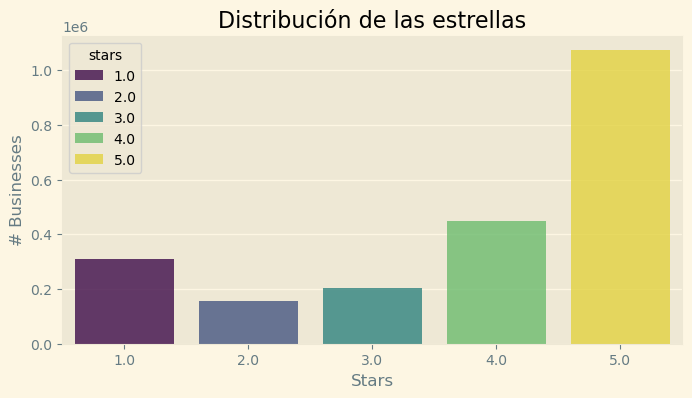

In [21]:
#Distribución grupal
x=df_data_review_pl['stars'].value_counts().sort('count', descending=True)
plt.figure(figsize=(8,4))
ax= sns.barplot(x='stars', y='count',data=x, alpha=0.8,hue='stars',palette='viridis')
plt.title("Distribución de las estrellas")
plt.ylabel('# Businesses', fontsize=12)
plt.xlabel('Stars', fontsize=12)
plt.show()

A continuación, realizamos la representación visual del top de establecimientos elegidos por la mayor cantidad de categorias usadas.

In [22]:
# A continuación filtra las reseñas por los business según las categorías seleccionadas  
df_data_reviews_filer_pl = df_data_review_pl.filter(
    pl.col('business_id').is_in(df_data_business_filer_pl['business_id'])
)
print('-' * 50)
print(f'Total de reseñas selecionadas de los establecimientos seleccionados {df_data_reviews_filer_pl.shape[0]} ' \
      'de un total de reseñas de: {df_data_review_pl.shape[0]}')
print('-' * 50)
display(df_data_reviews_filer_pl.head(2))

--------------------------------------------------
Total de reseñas selecionadas de los establecimientos seleccionados 239112 de un total de reseñas de: {df_data_review_pl.shape[0]}
--------------------------------------------------


review_id,user_id,business_id,stars,useful,funny,cool,text,date,length
str,str,str,f64,i64,i64,i64,str,str,u32
"""asXAASywqWEx4lS6PU-r_g""","""lTx02VrbU_YYRffLehyVgg""","""TgbI5_wXWa82NBVwkvC0yQ""",5.0,0,0,0,"""We've stayed at this Courtyard…","""2017-04-19 20:52:17""",256
"""RHEIRqDR3ykppn6Y1Hw9Yw""","""zzZPlDQdc1-NDP6tJxc25Q""","""Oom9PRZP9L57vHKQOA3q4g""",1.0,0,0,0,"""Very bad service and i took on…","""2017-06-06 23:59:55""",256


A continuación, la representación visual de la distribución de las estrellas de las reseñas para los establecimientos seleccionados.  En el grafico podremos ver como usaremos reseñas dentro de todo el conjunto posible de calificación.

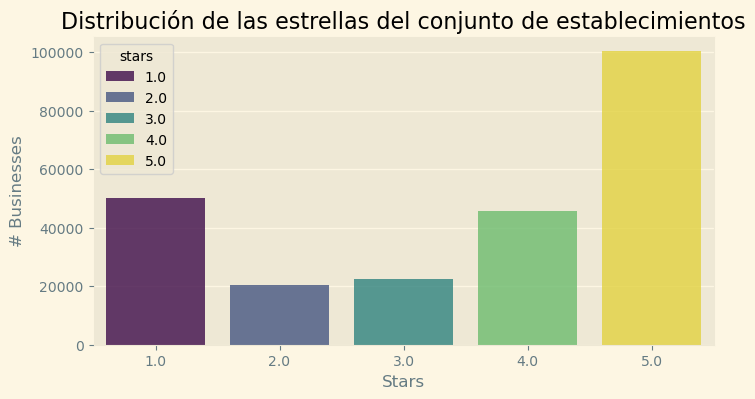

In [23]:
#Distribución grupal
x=df_data_reviews_filer_pl['stars'].value_counts().sort('count', descending=True)
plt.figure(figsize=(8,4))
ax= sns.barplot(x='stars', y='count',data=x, alpha=0.8,hue='stars',palette='viridis')
plt.title("Distribución de las estrellas del conjunto de establecimientos")
plt.ylabel('# Businesses', fontsize=12)
plt.xlabel('Stars', fontsize=12)
plt.show()

### Guardar las reseñas seleccionadas

In [24]:
# Guardar este DataFrame como archivo Parquet
df_data_reviews_selected_pl = df_data_reviews_filer_pl.select(pl.col('text'))
review_selected_file_path = f'{explicit_work_path}yelp_academic_dataset_review_selected.jsonl'
df_data_reviews_selected_pl.write_json(review_selected_file_path)

## The SFU Review Corpus - Negation Annotated

### Estructura de los datos

A continuación incluiremos la revisión EDA del dataset.

In [25]:
print(f"Iniciando el procesamiento del archivo: {sfu_review_file_path}")
df_sfu_lazy_business_pl:pl.lazyframe.frame.LazyFrame = None
try:
    #Lee el archivo especificado y no lo carga inmediatamente en la memoria
    df_sfu_lazy_business_pl = pl.scan_csv(sfu_review_file_path)
except Exception as e:
    print(f"\nOcurrió un error durante el procesamiento:")
    print(e)
else:
    print("La operación fue exitosa.")

Iniciando el procesamiento del archivo: ./fakereviews/SFU_Corpus.csv
La operación fue exitosa.


In [26]:
start_time=time.time()
try:
    df_sfu_data_pl:pl.dataframe.frame.DataFrame = df_sfu_lazy_business_pl.collect(engine='streaming')
except Exception as e:
    print(f"An error occurred: {e}")
else: 
    print(f"La operación fue exitosa en {time.time()-start_time:.2f}seg")  
    # Muestra las primeras 5 filas del DataFrame  
    display(df_sfu_data_pl.limit(25).head(5))  

La operación fue exitosa en 0.02seg


sentence,target
str,i64
"""I have read all of Grisham's b…",0
"""The story is about a lawyer wh…",0
"""There is no mystery to the sto…",1
"""Grisham's books are normally m…",1
"""This book does not have any su…",1


El siguiente paso es convertir los valores target 0 a Genuine negative y los valores 1 a Genuine positive.

In [27]:
#mapeo de los datos
sfu_mapping_values = {
    0: "Genuine negative",
    1: "Genuine positive"
}

# Definir la función Python que realiza la búsqueda en el diccionario
def map_value(value):
    return sfu_mapping_values.get(value)
# Tipo de dato de retorno (`return_dtype`)
return_dtype = pl.String

df_sfu_data_pl = df_sfu_data_pl.with_columns(
    pl.col("target").map_elements(map_value, return_dtype=return_dtype).alias("target")
)
display(df_sfu_data_pl.limit(25).head(5))  

sentence,target
str,str
"""I have read all of Grisham's b…","""Genuine negative"""
"""The story is about a lawyer wh…","""Genuine negative"""
"""There is no mystery to the sto…","""Genuine positive"""
"""Grisham's books are normally m…","""Genuine positive"""
"""This book does not have any su…","""Genuine positive"""


### Patrones visuales de los datos

A continuación realizaremos una exploración visual de los datos de SFU.

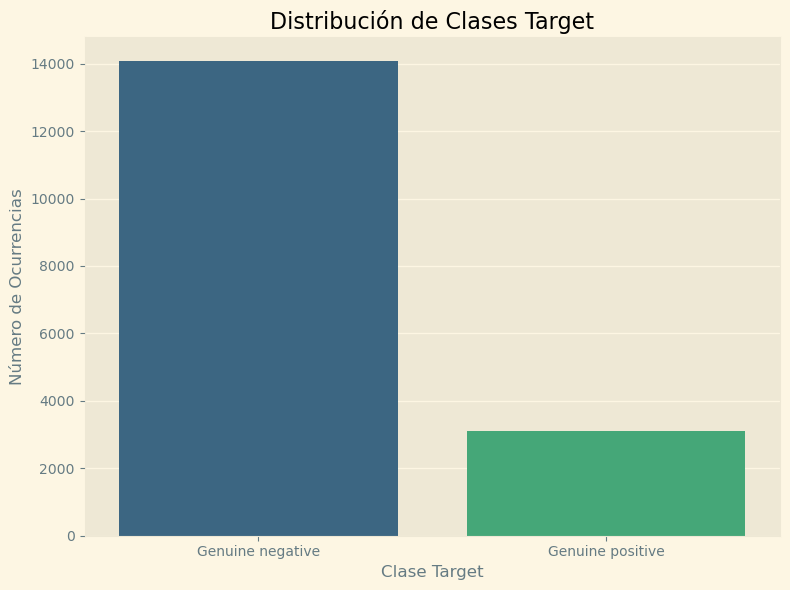

In [28]:
# --- Parte de la visualización ---

# Seaborn funciona mejor con DataFrames de Pandas, así que convertimos:
df_sfu_data_pd = df_sfu_data_pl.to_pandas()

# Creamos el gráfico de barras de conteo
plt.figure(figsize=(8, 6)) # Define el tamaño de la figura
sns.countplot(x='target', data=df_sfu_data_pd, palette='viridis', hue= 'target')

# Añade títulos y etiquetas
plt.title('Distribución de Clases Target', fontsize=16)
plt.xlabel('Clase Target', fontsize=12)
plt.ylabel('Número de Ocurrencias', fontsize=12)
plt.xticks(rotation=0) # Mantiene las etiquetas del eje x horizontales

# Muestra el gráfico
plt.tight_layout() # Ajusta el layout para evitar solapamiento
plt.show()

### Guardar las reseñas seleccionadas

In [29]:
# Guardar este DataFrame como archivo Parquet
review_selected_file_path = f'{explicit_work_path}sfu_dataset_review_selected.jsonl'
df_sfu_data_pl.write_json(review_selected_file_path)
print('Fichero guardado')

Fichero guardado


# Categorización de las reseñas por DeepSeek

A continuación, enviamos cada una de las reseñas seleccionados del dataset de Yelp para la categorización pora el modelo de IA DeepSeek.

In [2]:
# --- 1. Configuración de la API Key y Base URL de DeepSeek ---
try:
    deepseek_api_key = os.environ["DEEPSEEK_API_KEY"]
    deepseek_base_url = os.environ["DEEPSEEK_API_URL"]
    deepseek_time_out = os.environ['DEEPSEEK_TIMEOUT']
    print("Clave API y URL base de DeepSeek configuradas correctamente.")
except KeyError:
    print("Error: Las variables de entorno 'DEEPSEEK_API_KEY' o 'DEEPSEEK_BASE_URL' no están configuradas.")

Error: Las variables de entorno 'DEEPSEEK_API_KEY' o 'DEEPSEEK_BASE_URL' no están configuradas.


'/home/aam/fakereviews'

A continuación la creación del comportamiento del prompt

In [4]:
# Definición del Prompt de categorización, en ingles para facilitar la interpretación por la IA
classification_prompt_template = """
Classify the following customer review into a single category from the following:
- Genuine positive
- Genuine negative
- Fake positive
- Fake negative

Consider that 'Genuine' means the review appears to be from a real customer with an authentic experience (it may have nuances, mix positive and negative aspects, or be very detailed). 'Fake' means the review appears artificial, possibly promotional or defamatory (often exaggerated, generic, repetitive, or lacks credible details). 'Positive' or 'Negative' refer to the overall polarity of the sentiment expressed in the review.

Return only the name of the selected category, without additional explanations.

Review:
"""

A continuación una función para controlar la ultima ejecución del dataset y no iniciar desde el principio

In [5]:
# Lógica para reanudar el procesamiento
# Función para leer índices procesados
def get_processed_indices(temp_file_path: str) -> set[int]:
    """
    Lee el archivo temporal JSON Lines y devuelve un conjunto de índices
    de reseñas que ya han sido procesadas.

    Args:
        temp_file_path: La ruta al archivo temporal JSON Lines.

    Returns:
        Un conjunto de enteros representando los índices procesados.
    """
    processed_indices = set()
    if os.path.exists(temp_file_path):
        print(f"\nArchivo temporal '{temp_file_path}' encontrado. Leyendo índices procesados...")
        try:
            with open(temp_file_path, 'r', encoding='utf8') as f:
                for line_num, line in enumerate(f):
                    line = line.strip()
                    if not line: # Saltar líneas vacías
                        continue
                    try:
                        data = json.loads(line)
                        # Asumimos que el índice se guarda bajo la clave 'index'
                        if 'index' in data and isinstance(data['index'], int):
                            processed_indices.add(data['index'])
                        else:
                             print(f"Advertencia: Línea {line_num + 1} en '{temp_file_path}' no contiene un índice válido.")
                    except json.JSONDecodeError:
                        print(f"Advertencia: Ignorando línea no válida/incompleta en el archivo temporal (línea {line_num + 1}).")
                        # Si la decodificación falla, asumimos que es una línea parcial al final
                        break # Detener la lectura aquí
            print(f"Encontrados {len(processed_indices)} reseñas procesadas anteriormente.")
        except Exception as e:
            print(f"Error al leer el archivo temporal '{temp_file_path}': {e}")
            print("Se procesarán todas las reseñas desde el inicio por precaución.")
            processed_indices = set() # Si hay un error de lectura, empezar de cero
    else:
        print(f"\nArchivo temporal '{temp_file_path}' no encontrado. Iniciando procesamiento desde el inicio.")

    return processed_indices


A continuación inicia la conexión con DeepSeek para la categorización de las reseñas.

In [ ]:
start_time=time.time()
if deepseek_api_key and deepseek_base_url:
    print('Inicia procesamiento de los datos en DeepSeek')
    # --- Configurar el cliente de OpenAI para usar el endpoint de DeepSeek ---
    client = OpenAI(
        base_url=deepseek_base_url,
        api_key=deepseek_api_key,
        timeout=deepseek_time_out
    )
    # modelo de DeepSeek para tareas cotidianas
    deepseek_model_name = "deepseek-chat"

    # Lectura del fichero de las reseñas seleccionadas de yelp
    review_selected_file_path = f'{explicit_work_path}yelp_academic_dataset_review_selected.jsonl'
    df_data_reviews_selected_pl = pl.read_json(review_selected_file_path)
    print(f"\nTotal de reseñas a procesar: {df_data_reviews_selected_pl.shape[0]}")
    
    # Archivos de salida de las reseñas categorizadas
    reviews_categorize_output_file = f'{explicit_work_path}final_reviews_categorize.jsonl'

    # Obtener los índices ya procesados llamando a la nueva función
    processed_indices = get_processed_indices(reviews_categorize_output_file)

    # Abrir el archivo temporal
    with open(reviews_categorize_output_file, 'a', encoding='utf8') as reviews_file:
        # Iterar sobre las filas del DataFrame de Polars
        print(f"\nIniciando/Reanudando procesamiento")
        for row_index,review_row_text in enumerate(df_data_reviews_selected_pl.head(17000).select(['text']).iter_rows()):
            
            # --- Control de reanudación: Saltar si este índice ya fue procesado ---
            if row_index in processed_indices:
                #print(f"Saltando reseña con Índice {row_index}, ya procesada.")
                continue # Ir a la siguiente iteración del bucle

            # Esta reseña NO ha sido procesada
            review_text = review_row_text[0]
            current_identifier = row_index

            full_prompt_for_review = classification_prompt_template + review_text
            classification_result = "Error al procesar"
            processing_status = "Failed"
            error_message = ""

            #print(f"Procesando Índice: {current_identifier}.")

            try:
                api_time_start = time.time()
                # Conexión al API
                response = client.chat.completions.create(
                    model=deepseek_model_name,
                    messages=[
                        {"role": "user", "content": full_prompt_for_review}
                    ],
                    temperature=1.3,
                    max_tokens=20
                )

                classification_result = response.choices[0].message.content.strip()
                processing_status = "Success"
                print(f"Índice: {current_identifier}, Clasificación: {classification_result}, Tiempo: {time.time() - api_time_start:.2f}")

            except Exception as e:
                error_message = str(e)
                print(f"Error al procesar la reseña con Índice {current_identifier}: {error_message}")
                classification_result = "Error: " + error_message[:50]
                processing_status = "Failed"
                print(e)
                import traceback
                traceback.print_exc()

            # Preparar datos para guardar y escribir en el archivo
            result_data = {
                "index": current_identifier, # Guardamos el índice de la fila
                "review_text": review_text,
                "classification": classification_result,
                "processing_status": processing_status,
                "error_message": error_message
            }

            try:
                json_line = json.dumps(result_data, ensure_ascii=False)
                reviews_file.write(json_line + '\n')
                # Escribir en disco para no perder los datos en caso de fallo
                reviews_file.flush() 

            except Exception as write_error:
                print(f"ERROR FATAL: No se pudo escribir el resultado temporal para el Índice {current_identifier}: {write_error}")
                # Aquí podrías considerar detener el script sys.exit(1)

    print(f"\nFinalizado el bucle de procesamiento.")



else:
    print('No realizará la categorización de los datos en DeepSeek')
print(f'Total tiempo ejecución: {time.time() - start_time:.2f}')

Inicia procesamiento de los datos en DeepSeek

Total de reseñas a procesar: 239112

Archivo temporal '/home/aam/fakereviews/final_reviews_categorize.jsonl' encontrado. Leyendo índices procesados...
Encontrados 1000 reseñas procesadas anteriormente.

Iniciando/Reanudando procesamiento
Índice: 1000, Clasificación: Genuine negative, Tiempo: 5.02
Índice: 1001, Clasificación: Genuine positive, Tiempo: 5.89
Índice: 1002, Clasificación: Genuine negative, Tiempo: 5.82
Índice: 1003, Clasificación: Genuine positive, Tiempo: 4.28
Índice: 1004, Clasificación: Genuine positive, Tiempo: 5.72
Índice: 1005, Clasificación: Genuine positive, Tiempo: 6.39
Índice: 1006, Clasificación: Genuine positive, Tiempo: 4.65
Índice: 1007, Clasificación: Genuine positive, Tiempo: 6.45
Índice: 1008, Clasificación: Genuine negative, Tiempo: 4.55
Índice: 1009, Clasificación: Genuine positive, Tiempo: 5.24
Índice: 1010, Clasificación: Genuine positive, Tiempo: 4.32
Índice: 1011, Clasificación: Genuine positive, Tiempo: 

# Información de sesión

In [32]:
import session_info
session_info.show(html=False)

-----
dotenv              NA
kagglehub           0.2.7
matplotlib          3.10.0
numpy               2.0.1
openai              1.75.0
pandas              2.2.3
polars              1.27.1
pyarrow             16.1.0
seaborn             0.13.2
session_info        v1.0.1
-----
IPython             9.1.0
jupyter_client      8.6.3
jupyter_core        5.7.2
jupyterlab          4.3.4
notebook            7.3.2
-----
Python 3.12.2 | packaged by conda-forge | (main, Feb 16 2024, 20:50:58) [GCC 12.3.0]
Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39
-----
Session information updated at 2025-04-21 16:08


# Instalación librerías

!conda create --name tfm python=3.12.2

!conda activate tfm

!conda install -y conda-forge::polars=1.27.1

!conda install -y anaconda::pandas=2.2.3

!conda install -y seaborn=0.13.2

!conda install -y matplotlib=3.10.0

!conda install -c conda-forge pyarrow=16.1.0

!conda install -y conda-forge::python-dotenv-with-cli

!conda install -y conda-forge::openai=1.75.0

!conda install -y conda-forge::kaggle

!conda install -y anaconda::kagglehub

!conda install -y anaconda::jupyter

In [3]:
!conda install -y seaborn=0.13.2

Channels:
 - defaults
 - conda-forge
 - anaconda
Platform: linux-64
doneng package metadata (repodata.json): 
doneing environment: - 

# All requested packages already installed.



# Total ejecución del notebook

In [31]:
print(f'Total ejecución {time.time() - start_time_global:.2f} segundos')

Total ejecución 29.70 segundos
